In [1]:
import pandas as pd


cohort_file = "mak-etal-2017-mixed-8054891017613142248.csv"
cohort = pd.read_csv(cohort_file)

# Remove duplicate subject visits (i.e. only keep baseline visits)
cohort = cohort[cohort["MRI_ID"].str.contains("Baseline")]


In [2]:
from pathlib import Path
import re


def get_siena_results(patno: int):
    with Path("outputs", "fsl_siena", str(patno), "report.siena").open() as fin:
        return float(
            re.search("finalPBVC (?P<result>.*) %", fin.read()).groupdict()["result"]
        )


def get_viena_results(patno: int, debug: bool = False):
    with Path("outputs", "fsl_siena", str(patno), "report.viena").open() as fin:
        try:
            return float(
                re.search("finalPVVC (?P<result>.*) %", fin.read()).groupdict()[
                    "result"
                ]
            )
        except:
            if debug:
                print(f"[ERROR]: Cannot retrieve VIENA results for patient: {patno}")
            return None


# Comparisons of percentage brain volume change and ventricular enlargement


In [3]:
# cohort["PATNO"].map(lambda x: get_viena_results(x, debug=True))
cohort["SIENA"] = cohort["PATNO"].map(get_siena_results)
cohort["VIENA"] = cohort["PATNO"].map(get_viena_results)

# Find PD converters and stables
cohort.loc[
    (cohort["COGSTATE"] == 1) & (cohort["COGSTATE_NX"] == 1), "PD_CONVERT"
] = "stable"
cohort.loc[
    (cohort["COGSTATE"] == 1) & (cohort["COGSTATE_NX"] == 2), "PD_CONVERT"
] = "converter"

# Percentage of change for MoCA and UPDRS3
cohort["MOCA_PERC_CHANGE"] = (cohort["MCATOT_NX"] - cohort["MCATOT"]) / cohort["MCATOT"].abs() * 100
cohort["UPDRS3_PERC_CHANGE"] = (cohort["NP3TOT_NX"] - cohort["NP3TOT"]) / cohort["NP3TOT"].abs() * 100


In [4]:
# For now remove subject that failed VIENA preprocessing
siena_cohort = cohort[~cohort["VIENA"].isna()]
viena_cohort = cohort[~cohort["VIENA"].isna()]


In [5]:
from pingouin import ancova
from statsmodels.stats.multicomp import pairwise_tukeyhsd


## SIENA (PBVC)


In [6]:
siena_cohort.groupby("group").size()

group
hc        34
pd-mci    16
pd-nc     63
dtype: int64

In [7]:
ancova(
    data=siena_cohort,
    dv="SIENA",
    covar=["AGE_AT_VISIT", "SEX", "EDUCYRS"],
    between="group",
    effsize="n2",
)


,Source,SS,DF,F,p-unc,n2
0,group,5.186640,2,0.691550,0.503024,0.012698
1,AGE_AT_VISIT,0.458970,1,0.122392,0.727143,0.001124
2,SEX,1.395837,1,0.372222,0.543089,0.003417
3,EDUCYRS,0.182339,1,0.048624,0.825896,0.000446
4,Residual,401.251378,107,NaN,NaN,NaN


In [8]:
# Account for LEDD
ancova(
    data=siena_cohort,
    dv="SIENA",
    covar=["AGE_AT_VISIT", "SEX", "EDUCYRS", "LEDD"],
    between="group",
    effsize="n2",
)


,Source,SS,DF,F,p-unc,n2
0,group,3.329081e+00,1,1.094013e+00,0.299035,1.422558e-02
1,AGE_AT_VISIT,1.959309e+00,1,6.438741e-01,0.424916,8.372373e-03
2,SEX,2.444098e-01,1,8.031869e-02,0.777668,1.044394e-03
3,EDUCYRS,7.419525e-08,1,2.438227e-08,0.999876,3.170456e-10
4,LEDD,6.348941e+00,1,2.086408e+00,0.152894,2.712982e-02
5,Residual,2.221390e+02,73,NaN,NaN,NaN


In [9]:
tukey = pairwise_tukeyhsd(
    endog=siena_cohort["SIENA"],
    groups=siena_cohort["group"],
    alpha=0.05,
)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
    hc pd-mci   0.6194 0.5369 -0.7606 1.9993  False
    hc  pd-nc   0.3105 0.7273 -0.6581 1.2791  False
pd-mci  pd-nc  -0.3089 0.8333 -1.5831 0.9654  False
---------------------------------------------------


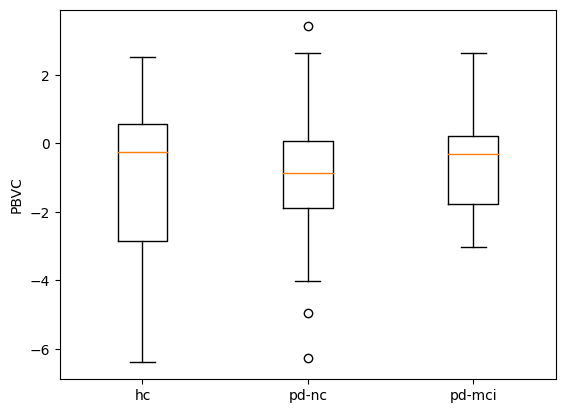

In [10]:
import matplotlib.pyplot as plt
import numpy as np


groups = ["hc", "pd-nc", "pd-mci"]
plt.boxplot([siena_cohort["SIENA"][siena_cohort["group"] == g] for g in groups])
plt.xticks(np.arange(len(groups)) + 1, groups)
plt.ylabel("PBVC")

plt.show()


## VIENA (PVVC)


In [11]:
viena_cohort.groupby("group").size()

group
hc        34
pd-mci    16
pd-nc     63
dtype: int64

In [12]:
ancova(
    data=viena_cohort,
    dv="VIENA",
    covar=["AGE_AT_VISIT", "SEX", "EDUCYRS"],
    between="group",
    effsize="n2",
)


,Source,SS,DF,F,p-unc,n2
0,group,1356.489295,2,0.899800,0.409705,0.016213
1,AGE_AT_VISIT,343.941416,1,0.456293,0.500819,0.004111
2,SEX,177.432844,1,0.235393,0.628545,0.002121
3,EDUCYRS,1133.359927,1,1.503583,0.222813,0.013546
4,Residual,80653.702327,107,NaN,NaN,NaN


In [13]:
tukey = pairwise_tukeyhsd(
    endog=viena_cohort["VIENA"], groups=viena_cohort["group"], alpha=0.05
)
print(tukey)


 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
    hc pd-mci -11.3959  0.357 -31.0727  8.2809  False
    hc  pd-nc  -7.4142 0.4121 -21.2258  6.3975  False
pd-mci  pd-nc   3.9818 0.8614 -14.1881 22.1517  False
-----------------------------------------------------


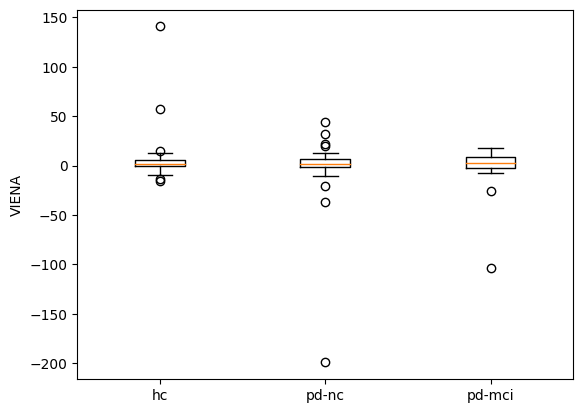

In [14]:
groups = ["hc", "pd-nc", "pd-mci"]
plt.boxplot([viena_cohort["VIENA"][viena_cohort["group"] == g] for g in groups])
plt.xticks(np.arange(len(groups)) + 1, groups)
plt.ylabel("VIENA")

plt.show()


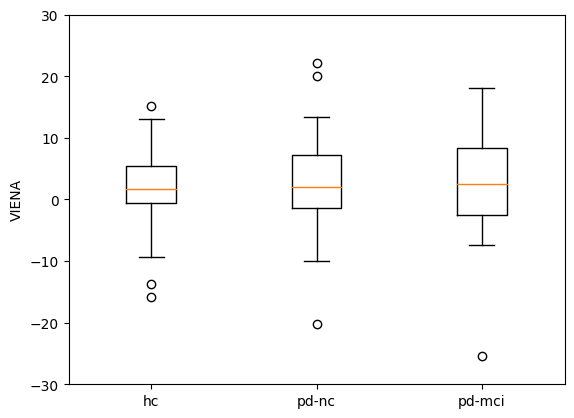

In [15]:
groups = ["hc", "pd-nc", "pd-mci"]
plt.boxplot([viena_cohort["VIENA"][viena_cohort["group"] == g] for g in groups])
plt.xticks(np.arange(len(groups)) + 1, groups)
plt.ylabel("VIENA")
plt.ylim(-30, 30)

plt.show()


## PD converters


In [16]:
cohort.groupby("PD_CONVERT").size()


PD_CONVERT
converter     9
stable       55
dtype: int64

### Whole-brain atrophy


In [17]:
ancova(
    data=siena_cohort[siena_cohort["PD_CONVERT"].notna()],
    dv="VIENA",
    covar=["AGE_AT_VISIT", "SEX", "EDUCYRS", "NP3TOT", "PDXDUR"],
    between="PD_CONVERT",
    effsize="n2",
)


,Source,SS,DF,F,p-unc,n2
0,PD_CONVERT,10.217440,1,0.012233,0.912332,0.000217
1,AGE_AT_VISIT,66.088593,1,0.079129,0.779537,0.001403
2,SEX,0.275571,1,0.000330,0.985573,0.000006
3,EDUCYRS,2.914400,1,0.003489,0.953109,0.000062
4,NP3TOT,621.115039,1,0.743670,0.392232,0.013185
5,PDXDUR,470.314794,1,0.563115,0.456206,0.009984
6,Residual,45936.125852,55,NaN,NaN,NaN


In [18]:
tukey = pairwise_tukeyhsd(
    endog=siena_cohort[siena_cohort["PD_CONVERT"].notna()]["SIENA"],
    groups=siena_cohort[siena_cohort["PD_CONVERT"].notna()]["PD_CONVERT"],
    alpha=0.05,
)
print(tukey)


 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
  group1  group2 meandiff p-adj   lower  upper  reject
------------------------------------------------------
converter stable  -0.7244 0.2882 -2.0762 0.6275  False
------------------------------------------------------


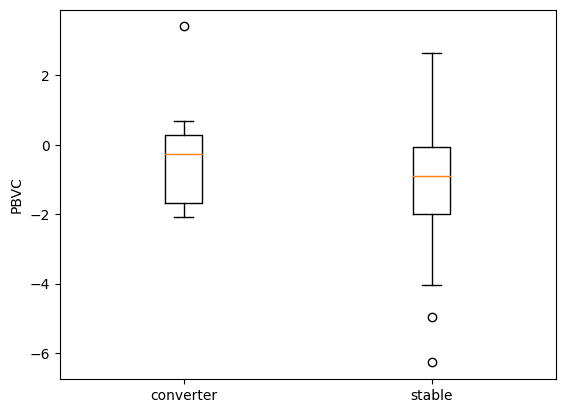

In [19]:
groups = ["converter", "stable"]
plt.boxplot([siena_cohort["SIENA"][siena_cohort["PD_CONVERT"] == g] for g in groups])
plt.xticks(np.arange(len(groups)) + 1, groups)
plt.ylabel("PBVC")

plt.show()


### Ventricular enlargement


In [20]:
ancova(
    data=siena_cohort[siena_cohort["PD_CONVERT"].notna()],
    dv="SIENA",
    covar=["AGE_AT_VISIT", "SEX", "EDUCYRS", "NP3TOT", "PDXDUR"],
    between="PD_CONVERT",
    effsize="n2",
)


,Source,SS,DF,F,p-unc,n2
0,PD_CONVERT,4.632301,1,1.644911,0.205032,0.025255
1,AGE_AT_VISIT,3.675635,1,1.305203,0.258214,0.020039
2,SEX,0.086358,1,0.030665,0.861632,0.000471
3,EDUCYRS,0.822765,1,0.292161,0.591022,0.004486
4,NP3TOT,16.913303,1,6.005846,0.017467,0.092209
5,PDXDUR,2.404525,1,0.853837,0.359505,0.013109
6,Residual,154.887696,55,NaN,NaN,NaN


In [21]:
tukey = pairwise_tukeyhsd(
    endog=viena_cohort[viena_cohort["PD_CONVERT"].notna()]["VIENA"],
    groups=viena_cohort[viena_cohort["PD_CONVERT"].notna()]["PD_CONVERT"],
    alpha=0.05,
)
print(tukey)


  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1  group2 meandiff p-adj   lower    upper  reject
--------------------------------------------------------
converter stable   0.1881 0.9858 -20.8519 21.2282  False
--------------------------------------------------------


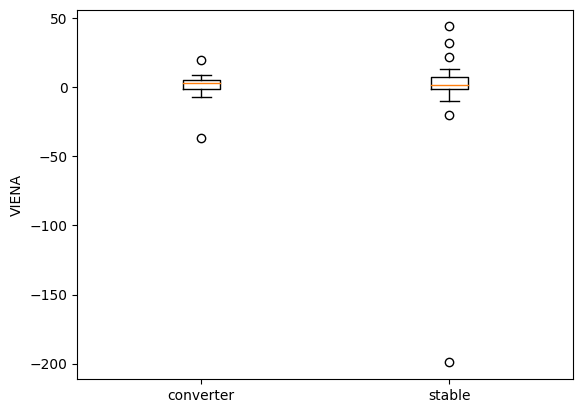

In [22]:
groups = ["converter", "stable"]
plt.boxplot([viena_cohort["VIENA"][viena_cohort["PD_CONVERT"] == g] for g in groups])
plt.xticks(np.arange(len(groups)) + 1, groups)
plt.ylabel("VIENA")

plt.show()


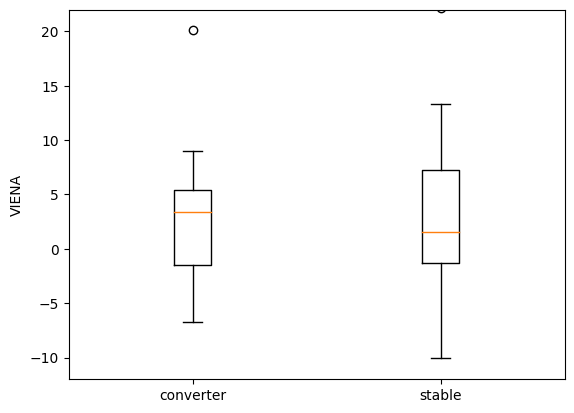

In [23]:
groups = ["converter", "stable"]
plt.boxplot([viena_cohort["VIENA"][viena_cohort["PD_CONVERT"] == g] for g in groups])
plt.xticks(np.arange(len(groups)) + 1, groups)
plt.ylabel("VIENA")
plt.ylim(-12, 22)

plt.show()


# Correlations of imaging outcome measures with clinical and cognitive functions


In [24]:
from pingouin import partial_corr

## PBVC

### MoCA

In [25]:
partial_corr(
    data=siena_cohort[siena_cohort["COHORT"] == 1],
    x="SIENA",
    y="MCATOT",
    covar=["AGE_AT_VISIT", "SEX", "LEDD"],
)


,n,r,CI95%,p-val
pearson,78,-0.012693,"[-0.24, 0.21]",0.913931


In [26]:
partial_corr(
    data=siena_cohort[siena_cohort["COHORT"] == 1],
    x="SIENA",
    y="MCATOT_NX",
    covar=["AGE_AT_VISIT", "SEX", "LEDD"],
)

,n,r,CI95%,p-val
pearson,79,-0.081055,"[-0.3, 0.15]",0.486392


In [27]:
partial_corr(
    data=siena_cohort[siena_cohort["COHORT"] == 1],
    x="SIENA",
    y="MOCA_PERC_CHANGE",
    covar=["AGE_AT_VISIT", "SEX", "LEDD"],
)

,n,r,CI95%,p-val
pearson,78,-0.066529,"[-0.29, 0.16]",0.570639


### UPDRS3

In [28]:
partial_corr(
    data=siena_cohort[siena_cohort["COHORT"] == 1],
    x="SIENA",
    y="NP3TOT",
    covar=["AGE_AT_VISIT", "SEX", "LEDD"],
)


,n,r,CI95%,p-val
pearson,78,0.270692,"[0.05, 0.47]",0.018828


In [29]:
partial_corr(
    data=siena_cohort[siena_cohort["COHORT"] == 1],
    x="SIENA",
    y="NP3TOT_NX",
    covar=["AGE_AT_VISIT", "SEX", "LEDD"],
)

,n,r,CI95%,p-val
pearson,79,0.315248,"[0.1, 0.5]",0.00554


In [30]:
partial_corr(
    data=siena_cohort[siena_cohort["COHORT"] == 1],
    x="SIENA",
    y="UPDRS3_PERC_CHANGE",
    covar=["AGE_AT_VISIT", "SEX", "LEDD"],
)

,n,r,CI95%,p-val
pearson,78,-0.075234,"[-0.3, 0.15]",0.521188


## Ventricular enlargement


### MoCA

In [31]:
partial_corr(
    data=viena_cohort[viena_cohort["COHORT"] == 1],
    x="VIENA",
    y="MCATOT",
    covar=["AGE_AT_VISIT", "SEX", "LEDD"],
)


,n,r,CI95%,p-val
pearson,78,-0.085392,"[-0.31, 0.14]",0.466349


In [32]:
partial_corr(
    data=viena_cohort[viena_cohort["COHORT"] == 1],
    x="VIENA",
    y="MCATOT_NX",
    covar=["AGE_AT_VISIT", "SEX", "LEDD"],
)

,n,r,CI95%,p-val
pearson,79,0.041574,"[-0.19, 0.26]",0.721403


In [33]:
partial_corr(
    data=viena_cohort[viena_cohort["COHORT"] == 1],
    x="VIENA",
    y="MOCA_PERC_CHANGE",
    covar=["AGE_AT_VISIT", "SEX", "LEDD"],
)

,n,r,CI95%,p-val
pearson,78,0.116317,"[-0.11, 0.33]",0.320325


### UPDRS3

In [34]:
partial_corr(
    data=viena_cohort[viena_cohort["COHORT"] == 1],
    x="VIENA",
    y="NP3TOT",
    covar=["AGE_AT_VISIT", "SEX", "LEDD"],
)


,n,r,CI95%,p-val
pearson,78,-0.116959,"[-0.34, 0.11]",0.317643


In [35]:
partial_corr(
    data=viena_cohort[viena_cohort["COHORT"] == 1],
    x="VIENA",
    y="NP3TOT_NX",
    covar=["AGE_AT_VISIT", "SEX", "LEDD"],
)

,n,r,CI95%,p-val
pearson,79,-0.022235,"[-0.25, 0.2]",0.8488


In [36]:
partial_corr(
    data=viena_cohort[viena_cohort["COHORT"] == 1],
    x="VIENA",
    y="UPDRS3_PERC_CHANGE",
    covar=["AGE_AT_VISIT", "SEX", "LEDD"],
)

,n,r,CI95%,p-val
pearson,78,0.111601,"[-0.12, 0.33]",0.340468
